In [22]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splprep, splev
import pandas as pd
from utils.line_of_symmetry import Mirror_Symmetry_detection

In [24]:
def read_csv(csv_path):
    """
    Reads CSV data and returns a list of curves.
    """
    data = pd.read_csv(csv_path, header=None).values
    path_XYs = []
    for i in np.unique(data[:, 0]):
        npXYs = data[data[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [25]:
def create_image_from_curves(curves, image_size=(500, 500), color=(255, 255, 255)):
    """
    Creates an image with curves drawn from the given list of curves.
    """
    image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    for curve in curves:
        for points in curve:
            if len(points) < 2:
                continue

            if len(points) == 2:
                cv2.line(image, tuple(map(int, points[0])), tuple(map(int, points[1])), color, 2)
                continue

            x = np.array([p[0] for p in points])
            y = np.array([p[1] for p in points])

            tck, u = splprep([x, y], s=0, k=2)
            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck, der=0)

            for i in range(len(x_new) - 1):
                cv2.line(image, (int(x_new[i]), int(y_new[i])), (int(x_new[i+1]), int(y_new[i+1])), color, 2)

    return image

In [26]:
def detect_harris_corners(image, num_corners=2, thresh_ratio=0.001):
    """
    Detects Harris corners in the provided image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    thresh = thresh_ratio * dst.max()

    # Find all corners above the threshold
    corners = np.argwhere(dst > thresh)
    corners = [(int(c[1]), int(c[0])) for c in corners]

    # Sort corners by their response value
    sorted_corners = sorted(corners, key=lambda pt: dst[pt[1], pt[0]], reverse=True)

    # Return the top `num_corners` corners
    return sorted_corners[:num_corners], image

In [27]:
def find_opposite_point(corner, line_coords):
    """
    Find the corresponding symmetric point on the opposite side of the symmetry line.
    """
    x1, y1, x2, y2 = line_coords
    x, y = corner

    line_vector = np.array([x2 - x1, y2 - y1])
    point_vector = np.array([x - x1, y - y1])
    line_length_squared = np.dot(line_vector, line_vector)
    if line_length_squared == 0:
        raise ValueError("Line of symmetry has zero length!")

    projection_length = np.dot(point_vector, line_vector) / line_length_squared
    projection = projection_length * line_vector
    closest_point_on_line = np.array([x1, y1]) + projection

    opposite_point = 2 * closest_point_on_line - np.array([x, y])

    return int(opposite_point[0]), int(opposite_point[1])

In [28]:
def draw_b_spline_curve(image, points, color=(0, 255, 0)):
    """
    Draws a B-spline curve connecting the given points on the image.
    """
    if len(points) < 2:
        return image

    if len(points) == 2:
        cv2.line(image, points[0], points[1], color, 2)
        return image

    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])

    tck, u = splprep([x, y], s=0, k=2)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)

    for i in range(len(x_new) - 1):
        cv2.line(image, (int(x_new[i]), int(y_new[i])), (int(x_new[i+1]), int(y_new[i+1])), color, 2)

    return image

In [29]:
def detecting_mirrorLine(image_path, csv_path, title):
    """
    Detects the line of symmetry in the image and finds the maximum Harris corners and their corresponding symmetric points.
    """
    curves = read_csv(csv_path)
    image_from_curves = create_image_from_curves(curves, image_size=(500, 500), color=(255, 255, 255))
    
    # Save and reload the image to ensure it gets processed correctly
    temp_image_path = 'curves_image.png'
    cv2.imwrite(temp_image_path, image_from_curves)
    image = cv2.imread(temp_image_path)
    
    # Detect the top 15 Harris corners
    corners, corner_image = detect_harris_corners(image, num_corners=15)

    mirror = Mirror_Symmetry_detection(temp_image_path)
    matchpoints = mirror.find_matchpoints()
    points_r, points_theta = mirror.find_points_r_theta(matchpoints)

    image_hexbin = plt.hexbin(points_r, points_theta, bins=200, cmap=plt.cm.Spectral_r)
    sorted_vote = mirror.sort_hexbin_by_votes(image_hexbin)
    r, theta = mirror.find_coordinate_maxhexbin(image_hexbin, sorted_vote, vertical=False)

    symmetry_line = mirror.draw_mirrorLine(r, theta, title)

    if symmetry_line:
        x1, y1, x2, y2 = symmetry_line

        # Draw the symmetry line on the image
        cv2.line(corner_image, (x1, y1), (x2, y2), (255, 255, 0), 2)  # Yellow for the symmetry line

        for corner in corners:
            opposite_point = find_opposite_point(corner, (x1, y1, x2, y2))

            # Draw the Harris corner and its corresponding symmetric point
            cv2.circle(corner_image, corner, 5, (0, 255, 0), 2)  # Green for the Harris corner
            cv2.circle(corner_image, opposite_point, 5, (255, 0, 0), 2)  # Red for the symmetric point

            # Draw B-spline connecting the points
            corner_image = draw_b_spline_curve(corner_image, [corner, opposite_point], color=(255, 165, 0))

        # Display the final image
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{title} - Harris Corners, Symmetric Points, and Symmetry Line")
        plt.show()

    """
    Detects the line of symmetry in the image and finds the maximum Harris corners and their corresponding symmetric points.
    """
    curves = read_csv(csv_path)
    image_from_curves = create_image_from_curves(curves, image_size=(500, 500), color=(255, 255, 255))
    
    # Save and reload the image to ensure it gets processed correctly
    temp_image_path = 'utils/output/algo1/curves_image.png'
    cv2.imwrite(temp_image_path, image_from_curves)
    image = cv2.imread(temp_image_path)
    
    # Detect the top 2 Harris corners
    corners, corner_image = detect_harris_corners(image, num_corners=15)

    mirror = Mirror_Symmetry_detection(temp_image_path)
    matchpoints = mirror.find_matchpoints()
    points_r, points_theta = mirror.find_points_r_theta(matchpoints)

    image_hexbin = plt.hexbin(points_r, points_theta, bins=200, cmap=plt.cm.Spectral_r)
    sorted_vote = mirror.sort_hexbin_by_votes(image_hexbin)
    r, theta = mirror.find_coordinate_maxhexbin(image_hexbin, sorted_vote, vertical=False)

    symmetry_line = mirror.draw_mirrorLine(r, theta, title)

    if symmetry_line:
        x1, y1, x2, y2 = symmetry_line

        for corner in corners:
            opposite_point = find_opposite_point(corner, (x1, y1, x2, y2))

            # Draw the Harris corner and its corresponding symmetric point
            cv2.circle(corner_image, corner, 5, (0, 255, 0), 2)  # Green for the Harris corner
            cv2.circle(corner_image, opposite_point, 5, (255, 0, 0), 2)  # Red for the symmetric point

            # Draw B-spline connecting the points
            corner_image = draw_b_spline_curve(corner_image, [corner, opposite_point], color=(255, 165, 0))

        # Display the final image
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{title} - Harris Corners and Symmetric Points")
        plt.show()

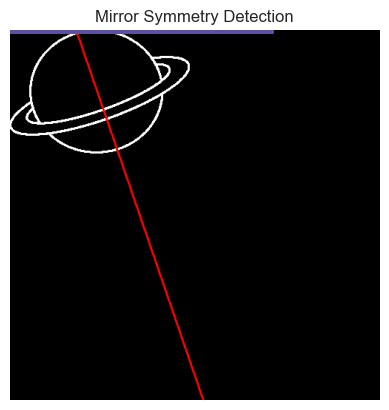

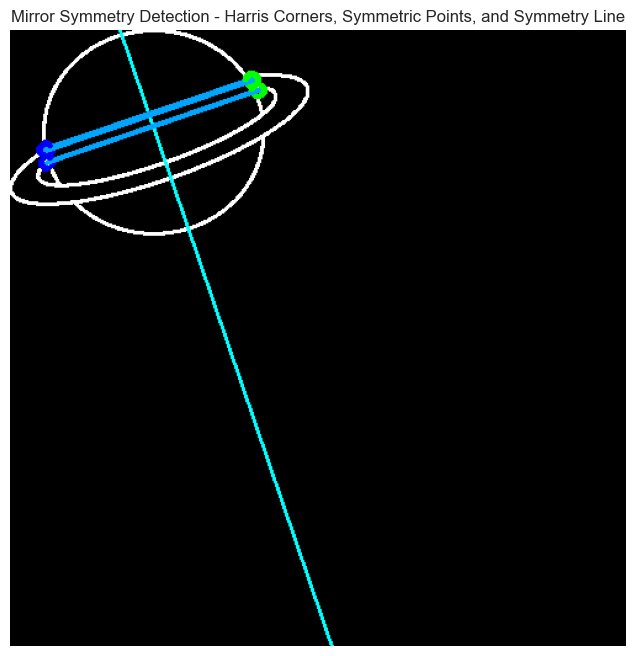

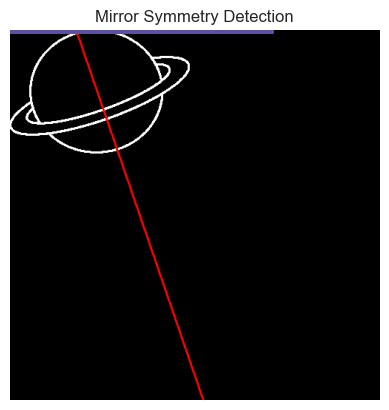

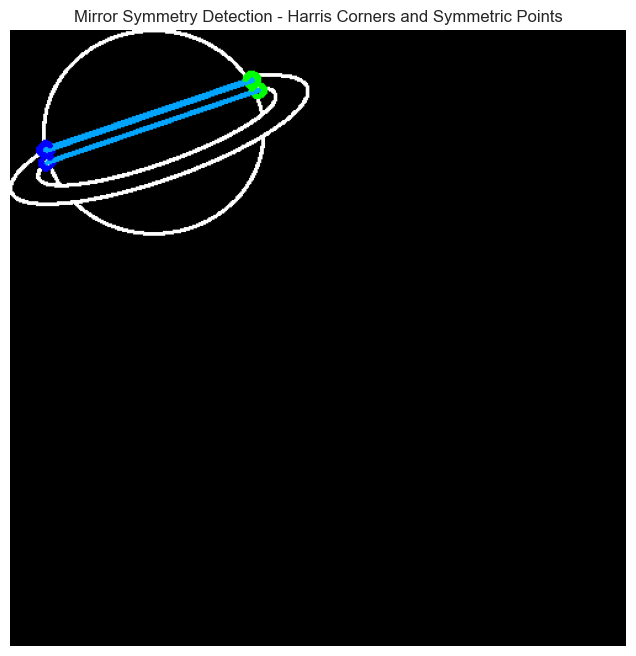

In [30]:
def main():
    image_path = 'utils/tc/occlusion2.png'
    csv_path = 'utils/tc/occlusion2.csv'  # Update this if you need CSV data for other purposes
    detecting_mirrorLine(image_path, csv_path, "Mirror Symmetry Detection")

if __name__ == '__main__':
    main()